# <center><font color = green> **Machine Learning cheat sheet** </center></color>

# Content
1. **[Preprocessing](#Preprocessing)**
- Train-test splitting
- SimlpleImputer, OrnialEncoder, OneHotEncoder, Custom Transformations, StandardScaler
- Pipelines, ColumnTransformer
- [Evaluation using cross validation](#Evaluation)
- [Hyperparameter tuning (Grid Search)](#tuning)
- [Saving models](#savingmodels)
2. **[Regression](#regression)**
- Performance measurement
- LinearRegression
- Gradient Descent
- [Polynomal Regression](#polynomalreg)
- Learning curves
- [Ridge, Lasso, Elastic Net Regression](#ridge)
- [SVM regression](#svmreg)
4. **[Classification](#Classification)**
- SGD Classifier
- SVM Classifier
- [Logit regression](#Logistic)
- Softmax regression
- [Performance measurement](#class_perf) (Accuracy, Confusion matrix, Precision, Recall, ROC curve)
5. [Decision Trees](#decisiontrees)
- [Decision Tree Regression](#decisiontreesreg)
- [Ensemble Learning and Random Forest](#ensemble)
- Bagging and Pasting
- Out-of-Bag Evaluation - evaulation on oob samples
- Random Patches and Random Subspaces - sampling features
- [Random Forrests; Feature importance](#randomForest)
- AdaBoost, GradientBoosting, Stacking
6. [Dimensionality reduction (PCA, LLE)](#pca)
- [Unsupervised learning (k-means, DBSCAN, Gaussian mix)](#unsupervised)
- Outlier detection

# Starting procedures

### Generating random data to demonstrate example code

In [1]:
# Data for regression demo
import numpy as np
import pandas as pd
np.random.seed(42) #to have the samles fixed on each new load
X_reg = 2 * np.random.rand(100, 1)
y_reg = 2 + 3 * X_reg + np.random.randn(100, 1)

# For clustering demo
from sklearn.datasets.samples_generator import make_blobs
X_cls, y_cls = make_blobs(n_samples= 1000, centers = 2 , cluster_std = 3.9,  n_features=2 , random_state= 11)

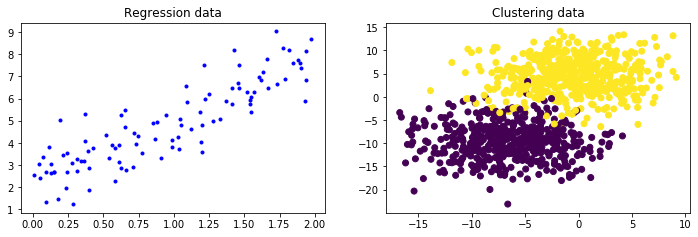

In [2]:
# Quick look at the data
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (12, 3.5))
plt.subplot(121).plot(X_reg, y_reg, "b.")
plt.title('Regression data')
plt.subplot(122).scatter(X_cls[:,0],X_cls[:,1], c = y_cls)
plt.title('Clustering data')
plt.show()

Good way to visualise correlations between features in a DataFrame is [scatter_matrix](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html)
or use sns.parplot() [sns.parplot docs](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

# Preprocessing <a name="Preprocessing"></a>

### Train-test splitting
Creating a training and testing data to evaluate the ML results

In [3]:
# Random sampling of data (uniform distribution)
from sklearn.model_selection import train_test_split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg,  test_size=0.2, random_state=42)

Stratified sampling makes it possible to have the same distribution of value within a feature in both train and test sample

In [4]:
# Stratified samlpling
from sklearn.model_selection import StratifiedShuffleSplit
# Creating random category for stratification example
X_reg_category = np.array(['Category 1' if x > 1 else 'Category 2' for x in X_reg])
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_reg,X_reg_category):   #Splitting X based on the distribution of X_reg_category
    X_reg_train_strat, X_reg_test_strat  = X_reg[train_index], X_reg[test_index]
    y_reg_train_strat, y_reg_test_strat  = y_reg[train_index], y_reg[test_index]

# Alternative method for getting the indexes of the stratified sampling
(train_index_alt, test_index_alt), = split.split(X_reg, X_reg_category)

### SimpleImputer - missing data handling
Fills in missing data with predefined values - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") #only can be used on numerical values
X_reg_miss = X_reg.copy()
X_reg_miss[2] = np.nan    #creating missing value
imputer.fit(X_reg_miss)
X_reg_trans = imputer.transform(X_reg_miss)
#imputer.fit_transform(X_reg) #fits and transforms the data at the same time
X_reg_miss[:4].T, imputer.statistics_, X_reg_trans[:4].T    #checking missing value, the median value and filled value

(array([[0.74908024, 1.90142861,        nan, 1.19731697]]),
 array([0.91213997]),
 array([[0.74908024, 1.90142861, 0.91213997, 1.19731697]]))

### OrdinalEncoder - strings to numbers
Converts strings into numbers - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)

In [6]:
ordinal = pd.DataFrame(['apple', 'pear', 'apple', 'lemon', 'pear', 'apple','lemon','lemon','apple'])
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
ordinal_cat = ordinal_encoder.fit_transform(ordinal)
ordinal_cat.T, ordinal_encoder.categories_

(array([[0., 2., 0., 1., 2., 0., 1., 1., 0.]]),
 [array(['apple', 'lemon', 'pear'], dtype=object)])

### OneHotEncoder - creating dummy variables from categorical values

Converts strings into numbers - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [7]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(drop = None, sparse = True) #default values are shown. Set sparse = False to get dense matrix
Dummy_matrix = cat_encoder.fit_transform(ordinal) 
cat_encoder.categories_, Dummy_matrix.toarray() # have to convert to dense matrix from sparse matrix to show values

([array(['apple', 'lemon', 'pear'], dtype=object)], array([[1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.]]))

### Creating custom transformations

In [8]:
# Example code which adds new columns
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
#housing_extra_attribs = attr_adder.transform(housing.values)

### StandardScaler - Feature scaling

transforms the data to 0 mean and 1 std - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #
X_scaled  = StandardScaler().fit_transform(X_cls)
X_cls[0], X_scaled[0]

(array([ -4.17801221, -10.09694501]), array([-0.12300716, -0.94508399]))

Other option to use MinMaxScaler to scale the data - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_cls[0], scaler.fit_transform(X_cls)[0]

(array([ -4.17801221, -10.09694501]), array([0.48502641, 0.34929146]))

### Pipelines - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
helps to perform sequences of transformations. The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a fit_transform() method).

When you call the pipeline’s fit() method, it calls fit_transform() sequentially on
all transformers, passing the output of each call as the parameter to the next call, until
it reaches the final estimator, for which it just calls the fit() method


In [11]:
from sklearn.pipeline import Pipeline
# Example for a transformation pipeline without an ML model
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
    ])
X_reg_transformed = num_pipeline.fit_transform(X_reg_miss)

### ColumnTransformer - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
We get the list of numerical column names and the list of categorical column names, and we
construct a ColumnTransformer. The constructor requires a list of tuples, where each
tuple contains a name22, a transformer and a list of names (or indices) of columns
that the transformer should be applied to. 

**!** *It applies each transformer to
the appropriate columns and concatenates the outputs along the second axis (the
transformers must return the same number of rows).*

When there is such a mix of sparse and dense matrices, the Colum
nTransformer estimates the density of the final matrix (i.e., the ratio of non-zero
cells), and it returns a sparse matrix if the density is lower than a given threshold (by
default, sparse_threshold=0.3).

you can specify the string "drop" if you
want the columns to be dropped. Or you can specify "pass
through" if you want the columns to be left untouched. By default,
the remaining columns (i.e., the ones that were not listed) will be
dropped, but you can set the remainder hyperparameter to any
transformer (or to "passthrough") if you want these columns to be
handled differently.

In [12]:
from sklearn.compose import ColumnTransformer
#Example syntax
num_attribs = ["rooms_per_household", "population_per_household", 'etc..']
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
#housing_prepared = full_pipeline.fit_transform(housing)

## Evaluation using cross validation - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) <a name="Evaluation"></a>
K-fold cross-validation feature. This method randomly splits the training set into K distinct subsets called folds, then it
trains and evaluates the chosen model K times, picking a different fold for
evaluation every time and training on the other K-1 folds. The result is an array con‐
taining the K evaluation scores.

Scikit-Learn’s cross-validation features expect a utility function
(greater is better) rather than a cost function (lower is better), so
the scoring function is actually the opposite of the MSE (i.e., a neg‐
ative value)

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, 
                         X_reg, y_reg,
                         scoring = "neg_mean_squared_error", #A string (see model evaluation documentation) or a scorer callable object / function with signature scorer(estimator, X, y) which should return only a single value
                         cv = 10)
rmse_scores = np.sqrt(-scores)
rmse_scores.mean(), rmse_scores

(0.9018865944759027,
 array([0.82685652, 0.7126126 , 0.5812089 , 1.13117797, 1.147818  ,
        0.92440466, 1.02412343, 0.72138795, 1.12284103, 0.82643489]))

Using $R^{2}$ as evaluation score:

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, 
                         X_reg_trans, y_reg,
                         scoring = "r2",
                         cv = 10)
scores.mean(), scores

(0.7071787857117989,
 array([0.57838775, 0.81972132, 0.77163001, 0.53135212, 0.41254925,
        0.82991085, 0.81582093, 0.86561398, 0.72822709, 0.71857456]))

In [15]:
# The below returns the predicted value for each fold in the crossvalidation
from sklearn.model_selection import cross_val_predict

## Hyperparameter tuning 
### Grid Searh - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) <a name="tuning"></a>
tell it which hyperparameters you want it to experiment with, and what values to
try out, and it will evaluate all the possible combinations of hyperparameter values,
using cross-validation. 

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

sgd_clf = linear_model.SGDClassifier(eta0 = 0.1, random_state=42)
param_grid = [
    # try 9 (3×3) combinations of hyperparameters
    {'learning_rate' : ['constant'] , 'max_iter': [100, 300, 1000], 'tol': [1e-1, 1e-2, 1e-3]},
    # then try 6 (2×3) combinations with learning_rate set as 'optimal'
    {'learning_rate' : ['invscaling'] , 'max_iter': [10, 300], 'tol': [1e-2, 1e-2, 1e-3]},
  ]
# train across 5 folds 
grid_search = GridSearchCV(sgd_clf, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(X_cls, y_cls)

C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.1, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'learning_rate': ['constant'],
                          'max_iter': [100, 300, 1000],
                          'tol': [0.1, 0.01, 0.001]},
                         {'learnin

In [17]:
# Show the best parameters and best estimator
grid_search.best_params_, grid_search.best_estimator_

({'learning_rate': 'invscaling', 'max_iter': 10, 'tol': 0.001},
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
               l1_ratio=0.15, learning_rate='invscaling', loss='hinge',
               max_iter=10, n_iter_no_change=5, n_jobs=None, penalty='l2',
               power_t=0.5, random_state=42, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False))

In [18]:
#Show the results of all the interations (only top 2 for now)
pd.DataFrame(grid_search.cv_results_)[0:2]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_iter,param_tol,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002022,0.002597,0.000794,0.000399,constant,100,0.1,"{'learning_rate': 'constant', 'max_iter': 100,...",0.905,0.970,...,0.959,0.028705,13,0.91250,0.97,0.95500,0.960,0.9375,0.947,0.020211
1,0.000987,0.000625,0.000460,0.000462,constant,100,0.01,"{'learning_rate': 'constant', 'max_iter': 100,...",0.970,0.965,...,0.962,0.012884,7,0.96375,0.96,0.95875,0.965,0.9725,0.964,0.004835


In [19]:
# Using the best model to train the whole training set
final_model = grid_search.best_estimator_
#final_model.fit()

### Randomized Search - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

param_distribution: Dictionary with parameters names (string) as keys and distributions or lists of parameters to try. Distributions must provide a rvs method for sampling (such as those from scipy.stats.distributions).

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import reciprocal, uniform

param_distribs = {
        'max_iter': randint(low=10, high=1000),
        'eta0': uniform(0.001, 0.1),
    }
sgd_clf = linear_model.SGDClassifier(random_state=42)

rnd_search = RandomizedSearchCV(sgd_clf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='accuracy', random_state=42)
rnd_search.fit(X_cls, y_cls)

C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, vali...
                                           verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'eta0': <

In [21]:
# Show the best parameters and best estimator
rnd_search.best_params_, rnd_search.best_estimator_

({'eta0': 0.03845401188473625, 'max_iter': 870},
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.03845401188473625,
               fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
               loss='hinge', max_iter=870, n_iter_no_change=5, n_jobs=None,
               penalty='l2', power_t=0.5, random_state=42, shuffle=True,
               tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False))

In [22]:
#Show the results of all the interations (only top 2 for now)
pd.DataFrame(rnd_search.cv_results_)[0:2]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta0,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003418,0.000831,0.000725,0.000967,0.038454,870,"{'eta0': 0.03845401188473625, 'max_iter': 870}",0.97,0.965,0.965,0.995,0.965,0.972,0.011662,1
1,0.003205,0.000965,0.000317,0.000418,0.0193435,81,"{'eta0': 0.01934347898661638, 'max_iter': 81}",0.97,0.940,0.965,0.995,0.965,0.967,0.017493,10


## Saving the models <a name="savingmodels"></a>
[joblib.dump()](https://joblib.readthedocs.io/en/latest/generated/joblib.dump.html)

In [23]:
from sklearn.externals import joblib
my_model = lin_reg.fit(X_reg_trans, y_reg)
joblib.dump(my_model, "my_model_test_for_ML_summary.pkl") #Saving the model
my_model_loaded = joblib.load("my_model_test_for_ML_summary.pkl") # Loading the model
my_model_loaded.coef_, my_model_loaded.predict(X_reg_trans)[0:2].T

C:\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


(array([[2.76573115]]), array([[4.30623422, 7.49332002]]))

----------------------------------------------------------------
# <center>Model descriptions </center>

## Regression <a name="regression"></a>

### Performance measurement

#### Root Mean Square Error (RMSE):

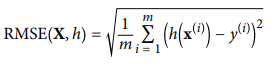

• Computing the root of a sum of squares (RMSE) corresponds to the Euclidean
norm: it is the notion of distance you are familiar with. It is also called the $ℓ_{2}$
norm, noted $∥ · ∥_{2}$ (or just ∥ · ∥).

#### Mean Absolute Error (MAE):

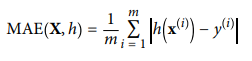

• Computing the sum of absolutes (MAE) corresponds to the ℓ1 norm, noted $∥ · ∥_{1}$ .
It is sometimes called the Manhattan norm because it measures the distance
between two points in a city if you can only travel along orthogonal city blocks.

• The higher the norm index, the more it focuses on large values and neglects small
ones. This is why the RMSE is more sensitive to outliers than the MAE. But when outliers are exponentially rare (like in a bell-shaped curve), the RMSE performs
very well and is generally preferred.

### LinerarRegression - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
Normal equation: 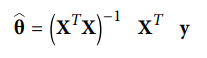

In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_reg, y_reg)
lin_reg.intercept_, lin_reg.coef_

(array([2.21509616]), array([[2.77011339]]))

### LinerarRegression using Gradient Descent
Partial Derivative of the cost function:
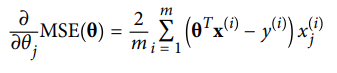

Gradient descent step size:
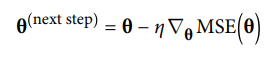

In [25]:
#example to the Batch GD method (each steps calculates with the whole dataset):
eta = 0.1  # learning rate
n_iterations = 1000
m = 100
X_b = np.c_[np.ones((100, 1)), X_reg] # adding ones for intercept calculation 
theta = np.random.randn(2,1)  # random initialization
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y_reg)
    theta = theta - eta * gradients
print('The coeffs in the linear regression with intercept: ' + str(theta.T) )

The coeffs in the linear regression with intercept: [[2.21509616 2.77011339]]


### Stochastich Gradient Descent [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)
Sensitive to feature scaling!

Stochastic Gradient Descent just
picks a random instance in the training set at every step and computes the gradients
based only on that single instance. 

Randomness is good to escape from local optima, but bad because it means
that the algorithm can never settle at the minimum. One solution to this dilemma is
to gradually reduce the learning rate. The steps start out large (which helps make
quick progress and escape local minima), then get smaller and smaller, allowing the
algorithm to settle at the global minimum. The function that determines the learning rate at each
iteration is called the learning schedule. 

In [26]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters
m = len(X_b)
def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y_reg[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
print('The coeffs in the linear regression using SGD: ' + str(theta.T) )

The coeffs in the linear regression using SGD: [[2.18520595 2.72995668]]


In [27]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, # number of epochs/iterations
                       tol=1e-3,      # iteration stops when the loss function drops by less than 'tol' (1e-3)
                       penalty=None,  # no panalty (deafult is 'l2')
                       eta0=0.1)      # starting learning rate
sgd_reg.fit(X_reg, y_reg.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([2.23094592]), array([2.78816701]))

### Mini-batch SGD
Mini-batches can be added with the model.partial_fit() method. [See short desc.](https://adventuresindatascience.wordpress.com/2014/12/30/minibatch-learning-for-large-scale-data-using-scikit-learn/)

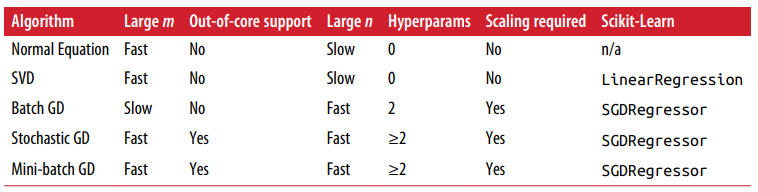
<center> *m* is the number of training instances and *n* is the number of features

## Linear SVR - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html)
SVM Regression
tries to fit as many instances as possible on the street while limiting margin violations
(i.e., instances off the street). The width of the street is controlled by a hyperparameter ϵ . Adding more training instances within the margin does not affect the model’s predictions; thus, the model is said to be ϵ-insensitive.

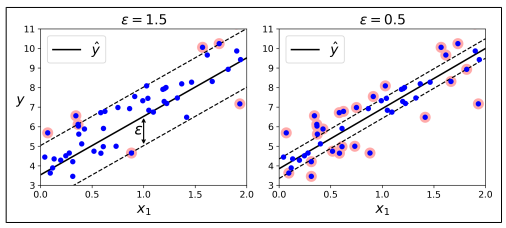

In [28]:
from sklearn.svm import LinearSVR
svm_reg = LinearSVR(epsilon=1)
svm_reg.fit(X_reg, y_reg.ravel())
svm_reg.intercept_, svm_reg.coef_

(array([1.95323121]), array([2.91315705]))

## Polynomal Regression <a name="polynomalreg"></a>

Using [PolynomalFeatures()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
By adding polynomal features, the new dataset can be added to the previous models

if there were
two features a and b, PolynomialFeatures with degree=3 would not only add the
features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations ab, $a^2$b, and a$b^2$

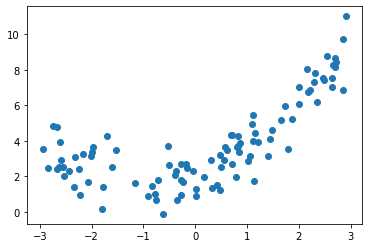

In [29]:
#Creating polynomal dataset
m = 100
X_pol = 6 * np.random.rand(m, 1) - 3
y_pol = 0.5 * X_pol**2 + X_pol + 2 + np.random.randn(m, 1)
plt.scatter(X_pol, y_pol)

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_pol)
X_poly[0,:]

array([0.82993344, 0.68878951])

In [31]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_pol)
lin_reg.intercept_, lin_reg.coef_

(array([2.11005759]), array([[0.9558374 , 0.51182025]]))

### SVR using polynomal kernel - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
The SVR class is the regression equivalent of the SVC class, and the LinearSVR class is the regression equivalent
of the LinearSVC class. The LinearSVR class scales linearly with the size of the training set (just like the LinearSVC class), while the **SVR class gets much too slow when
the training set grows large** (just like the SVC class)

In [32]:
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X_pol, y_pol.ravel())
svm_poly_reg.intercept_

C:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([2.35541822])

### Learning curves

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

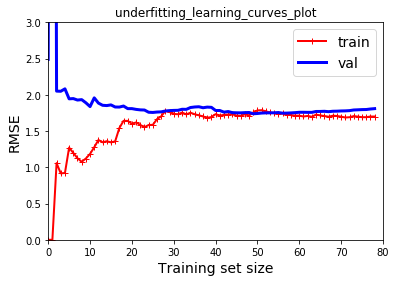

In [34]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X_pol, y_pol)
plt.axis([0, 80, 0, 3])                         
plt.title("underfitting_learning_curves_plot")  
plt.show()

Example for overfitting learning curves. There's a gap between the train and val learning curves

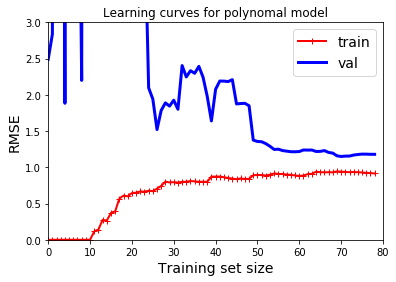

In [35]:
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])
plot_learning_curves(polynomial_regression, X_pol, y_pol)
plt.axis([0, 80, 0, 3])         
plt.title("Learning curves for polynomal model")  
plt.show()                        

## Ridge regression <a name="ridge"></a>

a regularization term is added to the cost function.
This forces the learning algorithm to not only fit the data but also keep the model
weights as small as possible. The hyperparameter α controls how much you want to regularize the model. If α = 0
then Ridge Regression is just Linear Regression. If α is very large, then all weights end
up very close to zero and the result is a flat line going through the data’s mean. 
Increasing α leads to flatter (i.e., less extreme, more reasonable) predictions; this
reduces the model’s variance but increases its bias.


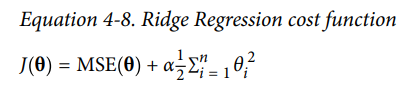

If we
define w as the vector of feature weights ($θ_1$ to $θ_n$), then the regularization term is
simply equal to ½$(∥ w ∥_2$$)^2$
, where $∥ w ∥_2$
 represents the $ℓ_2$ norm of the weight vector.
For Gradient Descent, just add αw to the MSE gradient vector 

**!Scale sensitive model!**

In [36]:
#Using closed form solution with sklearn:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X_reg, y_reg)
ridge_reg.intercept_, ridge_reg.coef_

(array([2.28736241]), array([[2.69326395]]))

 #### Using SGD for ridge
 Specifying "l2" indicates that you want SGD to add a regularization term to the cost function
equal to half the square of the ℓ2
 norm of the weight vector: this is simply Ridge Regression.

In [37]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X_reg, y_reg.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([2.26809525]), array([2.72180471]))

## Lasso regression
Least Absolute Shrinkage and Selection Operator Regression 

 it uses the $ℓ_1$ norm of the weight vector instead of half the square of the $ℓ_2$.
 norm

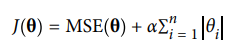

An important characteristic of Lasso Regression is that it tends to completely elimi‐
nate the weights of the least important features. Lasso Regression automatically performs feature selection and outputs a
sparse model.

In [38]:
#Closed formed
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.06)
lasso_reg.fit(X_reg, y_reg)
lasso_reg.intercept_, lasso_reg.coef_

(array([2.37608948]), array([2.59890973]))

In [39]:
#SGD with penalty using 'l1'
sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X_reg, y_reg.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([2.28620752]), array([2.7036965]))

## Elastic Net
Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The
regularization term is a simple mix of both Ridge and Lasso’s regularization terms,
and you can control the mix ratio r. When r = 0, Elastic Net is equivalent to Ridge
Regression, and when r = 1, it is equivalent to Lasso Regression
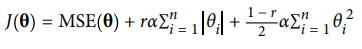

Ridge is a good
default, but if you suspect that only a few features are actually useful, you should prefer Lasso or Elastic Net since they tend to reduce the useless features’ weights down to
zero as we have discussed. In general, Elastic Net is preferred over Lasso since Lasso
may behave erratically when the number of features is greater than the number of
training instances or when several features are strongly correlated.

In [40]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_reg, y_reg.ravel())
elastic_net.intercept_, elastic_net.coef_

(2.6577460094552845, array([2.29939031]))

### Early Stopping
to stop training as soon as the validation error reaches a minimum. As the
epochs go by, the algorithm learns and its prediction error (RMSE) on the training set
naturally goes down, and so does its prediction error on the validation set. after a while the validation error stops decreasing and actually starts to go back up.
This indicates that the model has started to overfit the training data. With early stop‐
ping you just stop training as soon as the validation error reaches the minimum.

## SVM regression <a name="svmreg"></a>
- SVM Regression tries to fit as many instances as possible on the street while limiting margin violations(i.e., instances of the street)
- hyperparameter epsilon limits the margin violation (higher epsilon results in larger margin)

In [41]:
from sklearn.svm import LinearSVR
svm_reg = LinearSVR(epsilon=1)
svm_reg.fit(X_reg, y_reg.ravel())
svm_reg.intercept_, svm_reg.coef_

(array([1.95315369]), array([2.91319633]))

With SVM regression the kernel trick can also be used with 'poly' kernel

In [42]:
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma = 'auto')
svm_poly_reg.fit(X_pol, y_pol.ravel())

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# Classification <a name="Classification"></a>

## SGD Classifier - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [SGDCls vs logistic](https://towardsdatascience.com/how-to-make-sgd-classifier-perform-as-well-as-logistic-regression-using-parfit-cc10bca2d3c4)
- adventage of handling very large datasets efficiently
- SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning
- it computes a score based on a decision function,
and if that score is greater than a threshold, it assigns the instance to the positive
class, or else it assigns it to the negative class
- decision_function() method, which returns a score for each instanc

In [43]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_cls, y_cls)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
sgd_clf.decision_function([X_cls[0]])

array([-16.76597067])

## Linear SVM Classification
- fitting the widest possible street between the classes
- soft margin hyperparameter: **C** - smaller C value leads to a wider street but bit more margin violation
- sensitive to the scale of the features
- 'dual' paramater is better set to False unless there are more feature than training instances

In [45]:
from sklearn.svm import LinearSVC
linSVC = LinearSVC(C=0.01, loss="hinge", max_iter = 10e+5) 
linSVC.fit(X_cls, y_cls)
linSVC.predict(X_cls[0:3]), y_cls[0:3]

(array([0, 1, 0]), array([0, 1, 0]))

SGD can also be use to estimate linear SMV Classifiaction 

In [46]:
m=len(X_cls)
C= 1
SGD_svm = SGDClassifier(loss="hinge", alpha=1/(m*C))
SGD_svm.fit(X_cls, y_cls)
SGD_svm.predict(X_cls[0:3]), y_cls[0:3]

(array([0, 0, 0]), array([0, 1, 0]))

## Non-linear SVM Classification [docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
 - PolynomalFeatures and LinearSVC could be used but using the polynomal kernel trick makes calculation faster

In [47]:
from sklearn.datasets import make_moons
X_moon, y_moon = make_moons(n_samples=100, noise=0.15, random_state=42)

In [48]:
from sklearn.svm import SVC
polySVC = SVC(kernel="poly", degree=3, gamma = 'auto',
              coef0=1, #
              C=5)
polySVC.fit(X_moon, y_moon)
SGD_svm.predict(X_moon[0:3]), y_moon[0:3]

(array([1, 1, 1]), array([1, 1, 1], dtype=int64))

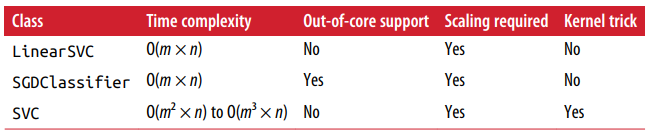

## Gaussian RBF Kernel - Similarity feature
- similarity function that measures how much each instance resembles a particular
landmark. For example, let’s take the one-dimensional dataset discussed earlier and
add two landmarks to it at $x_1$
 = –2 and $x_1$  = 1 (see the left plot in Figure 5-8). Next, let’s define the similarity function to be the Gaussian Radial Basis Function (RBF)
- . Increasing gamma makes the bell-shape curve narrower,  and as a result each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Small gamma value makes the bell-shaped curve wider, instances have a larger range of influence, and the decision boundary ends up smoother (if your model is overfitting, you should reduce it, and if it is underfitting, you should increase it)

## Logistic regression - [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) <a name="Logistic"></a>
- to estimate the probability that an instance belongs to a particular class
- cost function where *p*: is the estimated probability of a value belonging to a class
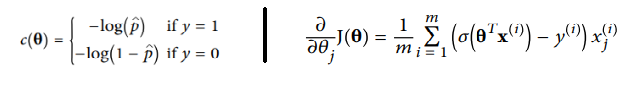
- no closed form solution but the derivative of log loss is convex so problem can be solved with finding the global minima
- the decision boundry is where the model predicts 50% chance for both classes
- model can be regularized using $ℓ_1$ and $ℓ_2$ penalties
- The hyperparameter controlling the regularization strength of a Scikit-Learn LogisticRegression model is not alpha (as in other linear models), but its inverse: C. The higher the value of C, the less the model is regularized

In [49]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver = 'lbfgs')
log_reg.fit(X_cls, y_cls)
log_reg.predict_proba([X_cls[0]])

array([[0.99829697, 0.00170303]])

### Multiclass Classification
- Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers.
- **one-versus-all (OvA) strategy**: to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score
- **one-versus-one (OvO)**: train a binary classifier for every pair of digits. one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. If there are N classes, you need to train N × (N – 1) / 2 classifiers. (When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the trainingset for the two classes that it must distinguish.)
- OvO is prefered when algos scale poorly with the size of the training set (eg.: SVMCls). However for most alogs OvA is prefered (Python automatically runs OvA). 

In [50]:
#Creating 3 labels for multiclass classification
X_clsn, y_clsn = make_blobs(n_samples= 1500, centers = 5 , cluster_std = 1.9,  n_features=2 , random_state= 42)
sgd_clf.fit(X_clsn, y_clsn)
scoresnclass = sgd_clf.decision_function([X_clsn[0]])
scoresnclass,  np.argmax(scoresnclass), sgd_clf.predict([X_clsn[0]]) #3 scores for each class, algo chooses the class with the highes score

(array([[ -40.9759479 ,    6.2643938 , -209.80381664, -949.48428479,
            2.25703949]]), 1, array([1]))

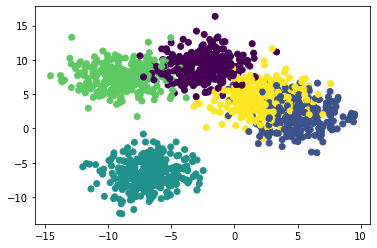

In [51]:
plt.scatter(X_clsn[:,0], X_clsn[:,1], c= y_clsn)

In [52]:
sgd_clf.classes_

array([0, 1, 2, 3, 4])

## Softmax Regression
**Multinomial Logistic Regression**
- computes a score $s_k$(x) for each class k, then estimates the probability of each class by applying the softmax function (also called the normalized exponential) to the scores
- ScikitLearn’s LogisticRegression uses one-versus-all by default when you train it on more than two classes, but you can set the multi_class hyperparameter to "multinomial" to switch it to Softmax Regression instead

In [53]:
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, max_iter = 10e+5)
softmax_reg.fit(X_clsn, y_clsn)
softmax_reg.predict([X_clsn[0]])

array([1])

#### Specificaly command sklearn to use Ova or OvO

In [54]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit( X_cls , y_cls)
ovr_clf.predict([X_cls[0]])

array([0])

### Multilabel Classification
- outputs multiple binary tags is called a multilabel classification system
- not all algo supports this

In [55]:
#Creating multiple labels
y_clsn_ajd = (y_clsn >= 4)
y_clsn_multi = np.c_[y_clsn ,y_clsn_ajd]
y_clsn_multi[0:3]

array([[1, 0],
       [4, 1],
       [3, 0]])

In [56]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_clsn, y_clsn_multi)
knn_clf.predict(X_clsn[0:3])

array([[1, 0],
       [4, 1],
       [3, 0]])

### Multiouput Classification
- classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255)

### Random Forest Classifiers
- sklearn can directly classify instances into multiple classes assigning probabilies to egy value belonging to a class.

In [57]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf,  X_cls , y_cls, cv=3,
                                    method="predict_proba")
y_probas_forest[0:3]

array([[1.  , 0.  ],
       [0.41, 0.59],
       [1.  , 0.  ]])

In [58]:
forest_clf.fit(X_cls , y_cls)
forest_clf.predict_proba( [X_cls[1]])

array([[0.11, 0.89]])

## Performance measurments <a name="class_perf"></a>

### Accuracy
How much percent of the predicted labeles were actually correctly predected by the model?




In [59]:
from sklearn.metrics import accuracy_score
print('The accuracy of the prediction is: ' + str(accuracy_score(y_cls, sgd_clf.predict(X_cls))))

The accuracy of the prediction is: 0.106


### Confusion Matrix

Each **row** in a confusion matrix represents an **actual class**, while **each column** repre‐
sents a **predicted class.**

In [60]:
from sklearn.model_selection import cross_val_predict
y_cls_pred = cross_val_predict(sgd_clf, X_cls, y_cls, cv = 3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_cls, y_cls_pred)

array([[482,  18],
       [ 19, 481]], dtype=int64)

In [61]:
y_clsn_pred = cross_val_predict(sgd_clf, X_clsn, y_clsn, cv=3)
conf_mx = confusion_matrix(y_clsn, y_clsn_pred)
conf_mx

array([[195,   0,   0,  15,  90],
       [  0, 269,   0,   0,  31],
       [  0,   0, 300,   0,   0],
       [  7,   0,   0, 268,  25],
       [ 21,  93,   0,   0, 186]], dtype=int64)

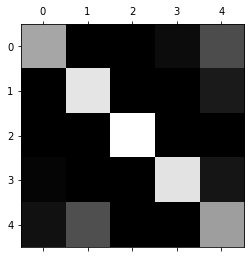

In [62]:
# Image representation of the consfusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)

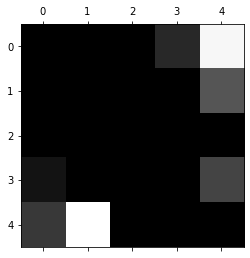

In [63]:
#Comparing error rates. On the below example the column 4 is brighter meaning a few points gets misclassified as class4.
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### Precision and Recall

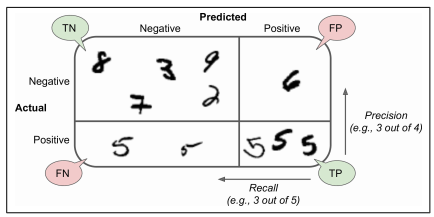

#### Precision - the accuracy of the positive predictions
$$ precision = \frac{TruePositive}{TruePositive + FalsePositive} $$
#### Recall (sensitivity / true positive rate) -  the ratio of positive instances that are correctly detected by the classifier
$$ recall = \frac{TruePositive}{TruePositive + FalseNegative} $$



In [64]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_cls, y_cls_pred), recall_score(y_cls, y_cls_pred)

(0.9639278557114228, 0.962)

#### $F_1$ score :  harmonic mean (gives more weight to low values) of precision and recall
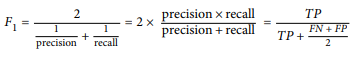

In [65]:
from sklearn.metrics import f1_score
f1_score(y_cls, y_cls_pred)

0.9629629629629629

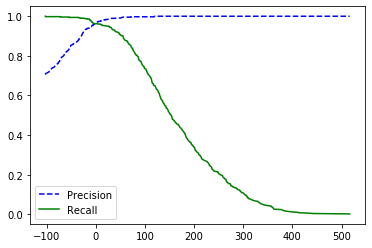

In [66]:
#Get the decision scores for all the instances
y_cls_scores = cross_val_predict(sgd_clf, X_cls, y_cls, cv=3,
                                     method="decision_function")
#computing all possible thresholds using 
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_cls, y_cls_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend()

#### [ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) -  receiver operating characteristic
- the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity.

- there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces

- One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 

- prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise

Text(0, 0.5, 'True Positive Rate (Recall)')

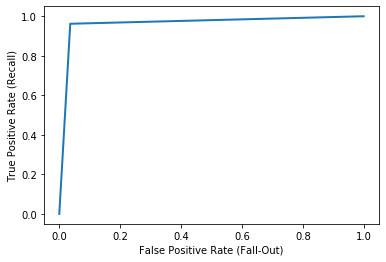

In [67]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_cls, y_cls_pred)
plt.plot(fpr, tpr, linewidth=2)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')

In [68]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_cls, y_cls_pred)

0.963

# Decision Trees [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) <a name="decisiontrees"></a>
- dont require feature scaling
- a node’s **gini** attribute measures its impurity: a node is “pure” (gini=0) if all training instances it applies to belong to he same class. gini impurity: ($p_k$ is the ratio of class k instances among the training instances in the $i^{th}$ node
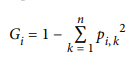
- Scikit-Learn uses the Classification And Regression Tree (CART) algorithm to train Decision Trees (also called “growing” trees). The idea is really quite simple: the algorithm first splits the training set in two subsets using a single feature k and a threshold $t_k$. How does it choose k and $t_k$ ? It searches for thepair (k, $t_k$) that produces the purest subsets (weighted by their size). Once it has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets and so on, recursively.
- Hyperparameters to control stopping contitions: 
    - **min_samples_split** (the minimum number of samples a node must have before it can be split)
    - **min_samples_leaf** (the minimum number of samples a leaf node must have)
    - **min_weight_fraction_leaf** (same as min_samples_leaf but expressed as a fraction of the total number of weighte dinstances)
    - **max_leaf_nodes** (maximum number of leaf nodes)
    - **max_features** (maximum number of features that are evaluated for splitting at each node)
- Increasing *min_* hyperparameters or reducing *max_* hyperparameters will regularize the model.
-  Scikit-Learn can speed up training by presorting the data (set presort=True), but this slows down training considerably for larger training sets
- **entorpy** can be used instead of impurity setting hte 'criterion' parameter. A set's entorpy is zero when it contains instances of only one class. 
- The depth of a well-balanced binary tree containing m leaves is equal to $log_2$$(m)^3$, rounded up

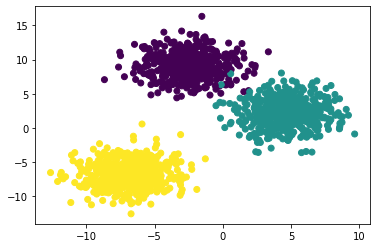

In [69]:
#Creating 3 labels for multiclass classification
X_cls3, y_cls3 = make_blobs(n_samples= 1500, centers = 3 , cluster_std = 1.9,  n_features=2 , random_state= 42)
plt.scatter(X_cls3[:,0], X_cls3[:,1], c= y_cls3)

In [70]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_cls3, y_cls3)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [71]:
#getting the probability of a random value
tree_clf.predict_proba([[2, 1.1]]), tree_clf.predict([[2, 1.1]])

(array([[0.02828283, 0.97171717, 0.        ]]), array([1]))

Visualising the decision tree [graphviz docs](#http://www.graphviz.org/documentation/)


You can convert this .dot file to a variety of formats such as PDF or PNG using the dot command-line tool from the graphviz package. This command line converts the .dot file to a .png image file in the anaconda promt (maek sure the file is in the root directory) :

*dot -Tpng iris_tree.dot -o iris_tree.png*

**!!** graphviz installation is tricky
1. In anaconda prompt use 'conda install python-graphviz' to install graphviz (delete with 'conda remove graphviz' if already installed
2. graphviz bin path have to be added to the os PATH

os.environ["PATH"] += ';C:\\Anaconda\\Library\\bin\\graphviz'

3. profit

In [72]:
#Visualising the Decision tree
from sklearn.tree import export_graphviz
export_graphviz(
     tree_clf,
     out_file=".\decision_tree_sample.dot",
     feature_names=['X1', 'X2'],
     class_names=['0','1','2'],
     rounded=True,
     filled=True
 )

In [73]:
from graphviz import Source

In [74]:
import os
os.environ["PATH"]  += ';C:\\Anaconda\\Library\\bin\\graphviz'

In [75]:
os.environ["PATH"] 

'C:\\Anaconda;C:\\Anaconda\\Library\\mingw-w64\\bin;C:\\Anaconda\\Library\\usr\\bin;C:\\Anaconda\\Library\\bin;C:\\Anaconda\\Scripts;C:\\Anaconda\\bin;C:\\Anaconda\\condabin;C:\\Anaconda;C:\\Anaconda\\Library\\mingw-w64\\bin;C:\\Anaconda\\Library\\usr\\bin;C:\\Anaconda\\Library\\bin;C:\\Anaconda\\Scripts;C:\\Program Files (x86)\\Common Files\\Oracle\\Java\\javapath;C:\\WINDOWS\\system32;C:\\WINDOWS;C:\\WINDOWS\\System32\\Wbem;C:\\WINDOWS\\System32\\WindowsPowerShell\\v1.0;C:\\WINDOWS\\System32\\OpenSSH;C:\\Program Files (x86)\\Microsoft SQL Server\\150\\DTS\\Binn;C:\\Users\\MateTorok\\AppData\\Local\\Microsoft\\WindowsApps;C:\\Users\\MateTorok\\AppData\\Local\\Programs\\Microsoft VS Code\\bin;.;C:\\Anaconda\\Library\\bin\\graphviz'

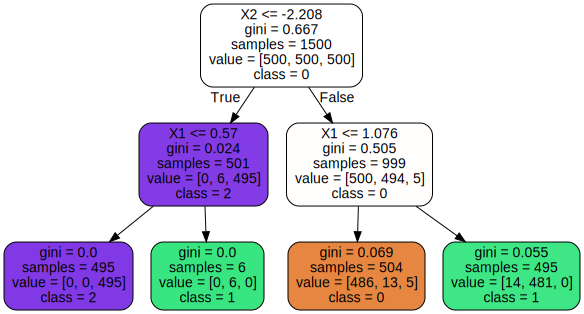

In [76]:
Source.from_file(".\decision_tree_sample.dot")

## Decesion Tree Regression <a name="decisiontreesreg"></a>
- predicts a value instead of a class which is the average target value of the n instances associated to the belonging leaf node
- The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value.
-  tries to split the training set in a way that minimizes the MSE instead of impurity
-  very sensitive to
small variations in the training data.

In [77]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X_pol, y_pol)
tree_reg.predict(X_pol[0:3]), y_pol[0:3].T, X_pol[0:3].T,

(array([3.9125611, 3.9125611, 3.9125611]),
 array([[3.71762486, 3.15733045, 3.16639862]]),
 array([[0.82993344, 1.39802172, 1.05675239]]))

# Ensemble Learning and Random Forest <a name="ensemble"></a>
- A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method.

### Voting Classifiers
-  aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a **hard voting** classifier
- **Soft voting:** If all classifiers are able to estimate class probabilities (i.e., they have a predict_proba() method), then you can tell scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. 

In [78]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [79]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                            

In [80]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### Bagging and Pasting [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)
- use the same training algorithm for every predictor, but to train them on different random subsets of the training set
- When sampling is performed with replacement, this method is called **bagging** (short forbootstrap aggregating)
- When sampling is performed without replacement, it is called **pasting**
- Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors (like hard voting or averaging)

In [81]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, # trains 500 decision tree classifiers
                             max_samples=100, # each trained on 100 instances randomly sampled
                             bootstrap=True, # set bootstrap to False to perform pasting
                             n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [82]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print('Bagging: ' + str(accuracy_score(y_test, y_pred)))
print('DecisionTree: ' + str(accuracy_score(y_test, y_pred_tree)))

Bagging: 0.904
DecisionTree: 0.856


#### Out-of-Bag Evaluation - evaulation on oob samples

BaggingClassifier samples *m* training instances with replacement (bootstrap=True), where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor.The remaining 37% of the training instances that are notsampled are called **out-of-bag (oob)** instances. (not the same 37% for all predictors)
You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training
oob decision function for each training instance is also available through the oob_decision_function_ variable

In [83]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_, bag_clf.oob_decision_function_[0]

(0.9013333333333333, array([0.42307692, 0.57692308]))

#### Random Patches and Random Subspaces - sampling features
two hyperparameters: max_features and bootstrap_features. They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.

Sampling both training instances and features is called the Random Patches method

Keeping all training instances (i.e., bootstrap=False and max_samples=1.0) but sampling features (i.e., bootstrap_features=True and/or max_features smaller than 1.0) is called the Random Subspaces method.

### Random Forests [read](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) <a name="randomForest"></a>

Random Forest is an ensemble of Decision Trees, generally trained via the bagging method tpically with max_samples set to the size of the training set

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees re grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance.

In [84]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100 , n_jobs= -1)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

### Feature Importance
Random Forests helps to meassure the relative importance of the features. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average. More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

In [85]:
rnd_clf.feature_importances_

array([0.43700726, 0.56299274])

###  Extremely Randomized Trees
 It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds.
 
You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier class.

## AdaBoost [desc](https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe)
or a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases

For example, to build an AdaBoost classifier, a first base classifier (such as a DecisionTree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

In [86]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
ada_clf.predict(X_train[0:3])

array([1, 0, 0], dtype=int64)

### Gradient Boosting
Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

*shrinkage* : The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. 

In [87]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=3, n_estimators=3, learning_rate=0.5)
gbrt.fit(X_reg, y_reg.ravel())
gbrt.predict(X_reg[0:3]), y_reg[0:3].T

(array([4.21985112, 7.02698774, 6.16901876]),
 array([[4.33428778, 7.40527849, 6.48372443]]))

python library XGBoost, which stands for Extreme Gradient Boosting. This package was initially developed by Tianqi Chen as part of the Distributed (Deep) Machine Learning Community (DMLC), and it aims at being extremely fast, scalable and portable

In [88]:
"""import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)"""

'import xgboost\nxgb_reg = xgboost.XGBRegressor()\nxgb_reg.fit(X_train, y_train)\ny_pred = xgb_reg.predict(X_val)'

### Stacking
To aggregate the ensemble prediction, Stacking method trains a model on the predictors to make a final prediction (blending).
Split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer)

# Dimensionality Reduction
## PCA [docs](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) [good read](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) <a name="pca"></a>
- set  svd_solve = 'randomized' to use Randomized PCA (default is auto)

In [89]:
#Creating 3D dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X_3d = np.empty((m, 3))
X_3d[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X_3d[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X_3d[:, 2] = X_3d[:, 0] * w1 + X_3d[:, 1] * w2 + noise * np.random.randn(m)

In [90]:
from sklearn.decomposition import PCA
C = PCA().fit(X_3d).components_

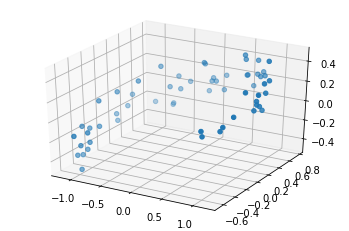

In [91]:
from mpl_toolkits.mplot3d import Axes3D
subplot3d = plt.subplot(111, projection='3d')
surface = subplot3d.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2])
#  --- drawing arrows from PCA!!???
plt.show()

In [92]:
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [93]:
pca.components_, pca.explained_variance_ratio_

(array([[-0.94556058,  0.32544614],
        [-0.32544614, -0.94556058]]), array([0.76412601, 0.23587399]))

In [94]:
# checking the variance explaned by eaxh component
pca = PCA()
pca.fit(X_3d)
cumsum = np.cumsum(pca.explained_variance_ratio_)
np.argmax(cumsum >= 0.95) + 1, pca.explained_variance_ratio_

(2, array([0.84248607, 0.14631839, 0.01119554]))

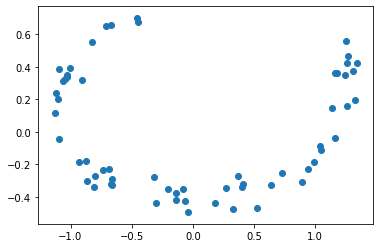

In [95]:
#PCA automatically calculates the best component value if n_components = float
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_3d)
plt.scatter(X_reduced[:,0], X_reduced[:,1])

## Incremental PCA
- split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time

In [96]:
"""#Example Code
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train) """

'#Example Code\nfrom sklearn.decomposition import IncrementalPCA\nn_batches = 100\ninc_pca = IncrementalPCA(n_components=154)\nfor X_batch in np.array_split(X_train, n_batches):\n    inc_pca.partial_fit(X_batch)\nX_reduced = inc_pca.transform(X_train) '

## Kernel PCA

In [97]:
from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X_3d)

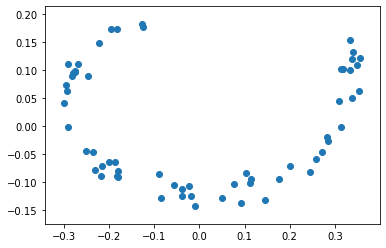

In [98]:
plt.scatter(X_reduced[:,0], X_reduced[:,1])

### Selecting a Kernel and Tuning Hyperparameters

In [99]:
from sklearn.datasets import make_swiss_roll
X_roll, t_roll = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y_roll  = t_roll > 6.9

clf = Pipeline([
 ("kpca", KernelPCA(n_components=2)),
 ("log_reg", LogisticRegression(solver = 'lbfgs'))
 ])
param_grid = [{
 "kpca__gamma": np.linspace(0.03, 0.05, 10),
 "kpca__kernel": ["rbf", "sigmoid"]
 }]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_roll, y_roll)
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [100]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

mean_squared_error(X, X_preimage)

0.07032392108407923

## LLE - Locally Linear Embedding
works by first measuring how each training instance linearly relates to its closest neighbors (c.n.), and then looking for a low-dimensional representation of the training set where these local relationships are best preserved 

In [101]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [102]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

## Other techniques
- Multidimensional Scaling (MDS)
- Isomap
- t-Distributed Stochastic Neightbor Embedding (t-SNE)
- Linear Discriminant Analysis (LDA)

# Unsupervised learning  <a name="unsupervised"></a>
##  K-means clustering [docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.
-------
- if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions. A few different random initialization might solve the problem. By defailt *n_init* is set to 10 and sklearn do this for you.
- measure each instance’s *affnity* with each cluster (affinity is any measure of how well an instance fits into a cluster). Each instance’s feature vector x can then be replaced with the vector of its cluster affinities. If there are k clusters, then this vector is k dimensional.
- For anomaly detection (also called outlier detection): any instance that has a low affinity to all the clusters is likely to be an anomaly.
-To use Elkan's (accelerated means) variant of K-Means, just set algorithm="elkan". Note that it does not support sparse data, so by default, Scikit-Learn uses "elkan" for dense data, and "full" (the regular K-Means algorithm) for sparse data

In [103]:
from sklearn.datasets import make_blobs
blob_centers = np.array( [[ 0.2,  2.3],     [-1.5 ,  2.3],     [-2.8,  1.8],     [-2.8,  2.8],     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

In [104]:
from sklearn.cluster import KMeans

In [105]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [106]:
kmeans.cluster_centers_, kmeans.labels_

(array([[-2.80389616,  1.80117999],
        [ 0.20876306,  2.25551336],
        [-2.79290307,  2.79641063],
        [-1.46679593,  2.28585348],
        [-2.80037642,  1.30082566]]), array([4, 0, 1, ..., 2, 1, 0]))

In [107]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new), kmeans.transform(X_new)

(array([1, 1, 2, 2]),
 array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
        [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
        [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
        [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]]))

In [108]:
kmeans.inertia_

211.5985372581684

### FInd the right number of clusters
the **_silhouette score_**, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

In [109]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [110]:
from sklearn.metrics import silhouette_score

In [111]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [112]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

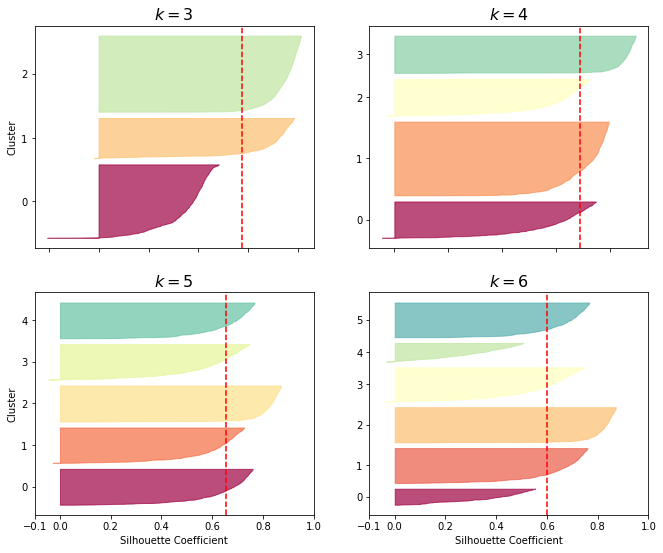

In [113]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

## Mini-Batch K-means
- If the dataset does not fit in memory, the simplest option is to use the `memmap` class

    *X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)*

- or:

In [114]:
from sklearn.cluster import MiniBatchKMeans
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [115]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

In [116]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [117]:
best_kmeans.score(X)

-211.64404010194994

## DBSCAN
- defines clusters as continuous regions of high density
- For each instance, the algorithm counts how many instances are located within a small distance ε (epsilon) from it. This region is called the instance’s εneighborhood
- If an instance has at least min_samples instances in its ε-neighborhood (including itself), then it is considered a core instance. In other words, core instances are those that are located in dense regions
- All instances in the neighborhood of a core instance belong to the same cluster. This may include other core instances, therefore a long sequence of neighboring core instances forms a single cluster.
- Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly

In [118]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [119]:
from sklearn.cluster import DBSCAN

In [120]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [121]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

In [122]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [123]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

## Other clustering algorithms
- [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering): a hierarchy of clusters is built from the bottom up
- [Birch](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html#sklearn.cluster.Birch): good for large datasets
- [Mean-shift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift):  starts by placing a circle centered on each instance, then for each circle it computes the mean of all the instances located within it, and it shifts the circle so that it is centered on the mean. Next, it iterates this mean-shift step until all the circles stop moving
- [Affnity propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation): uses a voting system, where instances vote for similar instances to be their representatives, and once the algorithm converges, each representative and its voters form a cluster. This algorithm can detect any number of clusters of different sizes
- [Spectral clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering):  this algorithm takes a similarity matrix between the instances and creates a low-dimensional embedding from it

## Gaussian mixtures
a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown.
The dataset **X** is assumed to have been generated through the following probabilistic process:
- For each instance, a cluster is picked randomly among k clusters. The probability of choosing the jth cluster is defined by the cluster’s weight ϕ(j). The index of the cluster chosen for the i-th instance is noted z(i)
- If z(i)=j, meaning the ith instance has been assigned to the jth cluster, the location x(i) of this instance is sampled randomly from the Gaussian distribution with mean μ(j) and covariance matrix Σ(j).
----------
**ExpectationMaximization (EM)** algorithm, which has many similarities with the K-Means algorithm: it also initializes the cluster parameters randomly, then it repeats two steps until convergence, first assigning instances to clusters (this is called the expectation step) then updating the clusters (this is called the maximization step). Indeed, in the context of clustering you can think of EM as a generalization of KMeans which not only finds the cluster centers (μ)(1) to μ(k), but also their size, shape and orientation (Σ)(1) to Σ(k), as well as their relative weights ϕ(1) to ϕ(k). Unlike KMeans, EM uses soft cluster assignments rather than hard assignments: for each instance during the expectation step, the algorithm estimates the probability that it belongs to each cluster (based on the current cluster parameters). Then, during the maximization step, each cluster is updated using all the instances in the dataset, with each instance weighted by the estimated probability that it belongs to that cluster. These probabilities are called the responsibilities of the clusters for the instances. During the maximization step, each cluster’s update will mostly be impacted by the instances it is most responsible for.  Unfortunately, just like K-Means, EM can end up converging to poor solutions, so it needs to be run several times, keeping only the best solution. **Set n_init to 10.** Be careful: by default n_init is only set to 1.

---------
covariance_type hyperparameter to one of the following values: (default is 'full' meaning a cluster can take on any shape)
- "spherical": all clusters must be spherical, but they can have different diameters (i.e., different variances).
- "diag": clusters can take on any ellipsoidal shape of any size, but the ellipsoid’s axes must be parallel to the coordinate axes (i.e., the covariance matrices must be diagonal).
- "tied": all clusters must have the same ellipsoidal shape, size and orientation (i.e., all clusters share the same covariance matrix).


In [124]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [125]:
from sklearn.mixture import GaussianMixture

In [126]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [127]:
gm.weights_, gm.means_, gm.covariances_

(array([0.20965228, 0.4000662 , 0.39028152]),
 array([[ 3.39909717,  1.05933727],
        [-1.40763984,  1.42710194],
        [ 0.05135313,  0.07524095]]),
 array([[[ 1.14807234, -0.03270354],
         [-0.03270354,  0.95496237]],
 
        [[ 0.63478101,  0.72969804],
         [ 0.72969804,  1.1609872 ]],
 
        [[ 0.68809572,  0.79608475],
         [ 0.79608475,  1.21234145]]]))

In [128]:
gm.predict(X), gm.predict_proba(X)

(array([2, 2, 1, ..., 0, 0, 0], dtype=int64),
 array([[2.32389467e-02, 6.77397850e-07, 9.76760376e-01],
        [1.64685609e-02, 6.75361303e-04, 9.82856078e-01],
        [2.01535333e-06, 9.99923053e-01, 7.49319577e-05],
        ...,
        [9.99999571e-01, 2.13946075e-26, 4.28788333e-07],
        [1.00000000e+00, 1.46454409e-41, 5.12459171e-16],
        [1.00000000e+00, 8.02006365e-41, 2.27626238e-15]]))

In [129]:
gm.converged_, gm.n_iter_

(True, 4)

In [130]:
# estimate the log of the probability density function (PDF) at any location using the score_samples() method:
gm.score_samples(X)

array([-2.60782346, -3.57106041, -3.33003479, ..., -3.51352783,
       -4.39802535, -3.80743859])

PLotting the distribution and contour plot of the data:

In [131]:
from matplotlib.colors import LogNorm
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

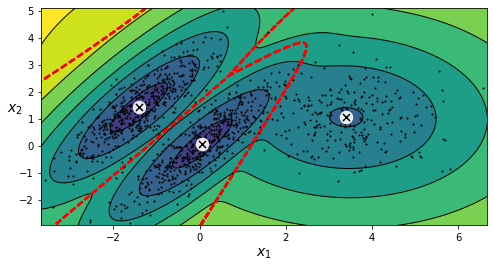

In [132]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.show()

### Anomaly detection

In [133]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

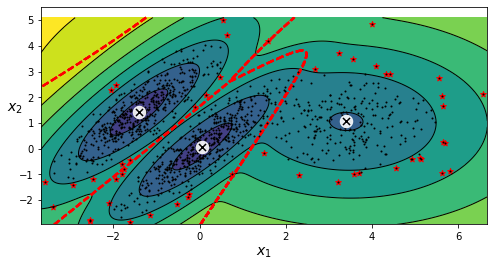

In [134]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.show()

### Selecting the number of clusters
 try to find the model that minimizes a theoretical information criterion such as the Bayesian information criterion (BIC) or the Akaike information criterion (AIC)
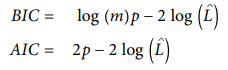
Both the BIC and the AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well. They often end up selecting the same model, but when they differ, the model selected by the BIC tends to be simpler (fewer parameters) than the one selected by the AIC, but it does not fit the data quite as well (this is especially true for larger datasets).


In [135]:
gm.bic(X), gm.aic(X)

(8189.74345832983, 8102.518178214792)

In [137]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

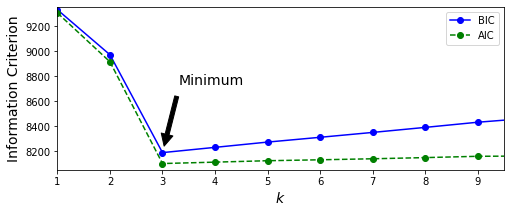

In [139]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

### Bayesian Gaussian Mixture

it is possible to use instead the BayesianGaussianMixture class which is capable of giving weights equal (or close) to zero to unnecessary clusters. Just set the number of clusters n_components to a value that you have good reason to believe is greater than the optimal number of clusters (this assumes some minimal knowledge about the problem at hand), and the algorithm will eliminate the unnecessary clusters automatically. 

Prior knowledge about the latent variables z can be encoded in a probability distribution p(z) called the prior. For example, e may have a prior belief that the clusters are likely to be few (low concentration), or conversely, that they are more likely to be plentiful (high concentration). This can be adjusted using the weight_concentration_prior hyperparameter

In [140]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

### Other techniques detecting outliers

- [Fast-MCD](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html) : this algorithm is useful for outlier detection, in particular to cleanup a dataset. t. It assumes that the normal instances (inliers) are generated from a single Gaussian distribution (not a mixture), but it also assumes that the dataset is contaminated with outliers that were not generated from this Gaussian distribution. 
- [Isolation forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) : this is an efficient algorithm for outlier detection, especially in high-dimensional datasets. The algorithm builds a Random Forest in which each Decision Tree is grown randomly: at each node, it picks a feature randomly, then it picks a random threshold value (between the min and max value) to split the dataset in two. The dataset gradually gets chopped into pieces this way, until all instances end up isolated from the other instances. An anomaly is usually far from other instances, so on average (across all the Decision Trees) it tends to get isolated in less steps than normal instances.
-  [Local outlier factor (LOF)](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html) :this algorithm is also good for outlier detection. It compares the density of instances around a given instance to the density around its neighbors. An anomaly is often more isolated than its k nearest neighbors
- [One-class SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html):  this algorithm is better suited for novelty detection.  Since we just have one class of instances, the one-class SVM algorithm instead tries to separate the instances in high-dimensional space from the origin. In the original space, this will correspond to finding a small region that encompasses all the instances. If a new instance does not fall within this region, it is an anomaly